## CNN Classifier V2 - Vacation Images

This version will reduce the image size from 128x128 to 64x64 pixels and will reduce convolutional filter from 5x5 to 3x3.
Inputs v1: 2704, Inputs v2: 784.  
Hopefully computational costs will be reduced and accuracy still be high enough.

### Imports

In [1]:
#general
import numpy as np
import splitfolders
import time
from datetime import datetime 
from time import gmtime, strftime
from tqdm import tqdm

#pytorch
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

#visualization
import matplotlib.pyplot as plt

### Script Runtime Start

In [2]:
def start_time_():    
    start_time = time.time()
    return(start_time)

def end_time_():
    end_time = time.time()
    return(end_time)

def Execution_time(start_time_,end_time_):
    return(strftime("%H:%M:%S",gmtime(int('{:.0f}'.format(float(str((end_time_-start_time_))))))))

In [3]:
script_start = start_time_()

### Initialize GPU

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Creating Folder Structure

The original folder containing the 2 subclass folder has to be split into subfolders for train, validation and test.

`Original:`  
* Data
    * Person
    * Scene
---
`New:`
* Data
    * train (70% of total)
        * Person
        * Scene
    * val (10% of total)
        * Person
        * Scene
    * test (20% of total)
        * Person
        * Scene

In [5]:
## Following Code does the described above

# input_folder = 'Data/'
# output_folder = 'img_data/'

# splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(0.7, 0.1, 0.2))

In [6]:
#paths to be used for dataloaders later on
path_to_train = './img_data/train/'
path_to_val = './img_data/val/'
path_to_test = './img_data/test/'

### Define data tranformations

In [7]:
mean = [0.4939, 0.5189, 0.5326] #calculated in seperate notebook file
std = [0.2264, 0.2398, 0.2707] #calculated in seperate notebook file


#for training a litte augmentation (random flip, grayscale and rotation) will be performed
train_transforms = T.Compose([
    T.Resize([64,]),
    T.CenterCrop([64,]),
    T.RandomHorizontalFlip(0.3),
    T.RandomGrayscale(0.1),
    T.RandomRotation(30),
    T.ToTensor(),
    T.Normalize(torch.tensor(mean), torch.tensor(std))
])

#no augmentation needed, therefore only reszing, to tensor and normalizing
val_transforms = T.Compose([
    T.Resize([64,]),
    T.CenterCrop([64,]),
    T.ToTensor(),
    T.Normalize(torch.tensor(mean), torch.tensor(std))
])

#no augmentation needed, therefore only reszing, to tensor and normalizing
test_transforms = T.Compose([
    T.Resize([64,]),
    T.CenterCrop([64,]),
    T.ToTensor(),
    T.Normalize(torch.tensor(mean), torch.tensor(std))
])

### Initialize Datasets (Train, Validation, Test)

In [8]:
#Create datasets, labling is done with "ImageFolder"-Method
train_dataset = torchvision.datasets.ImageFolder(root=path_to_train, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root=path_to_val, transform=val_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=path_to_test, transform=test_transforms)

classes = ('person', 'scene')

### Initialize DataLoaders for the Datasets

In [9]:
#Define Loaders



#==============#
batch_size = 16
#==============#



train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

### Unnormalize pictures for visualization later

In [10]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

### Define Image viewer

In [11]:
def imshow(img):
    de_norm = UnNormalize(mean=(0.4939, 0.5189, 0.5326), std=(0.2264, 0.2398, 0.2707))
    img = de_norm(img)      # unnormalize
    npimg = img.cpu().numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

### Define CNN 

In [12]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding = 1) #input_dim = 64, output_dim = 64
        self.pool = nn.MaxPool2d(2,2) #(kernelsize, stride)
        self.conv2 = nn.Conv2d(6, 16, 3, padding = 1) # input_dim = 32 (after pooling). output_dim (after 2nd pooling) = 16
        self.conv3 = nn.Conv2d(16, 16, 3) # input_dim = 16 , output_dim (after 3rd pooling)= 7
        
        self.fc1 = nn.Linear(16 * 7 * 7, 120) #(16 channel * 7 * 7 (image size))
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, 2)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [13]:
cnn = CNN().to(device)

### Define loss function and optimizer

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.5)

### Train network

In [15]:
#=========#
epochs = 100
#=========#

In [16]:
#splitted from below, to run more epochs if needed without setting loss lists to zero
train_loss = []  
validation_loss = []
min_valid_loss = np.inf  #value to distinguish if model will be saved or not. If val loss lower, model will be saved

In [17]:
#Starting Time 
train_start = start_time_()


#Training Iterations
#==========================================================================
for epoch in range(epochs):  # loop over the dataset multiple times
    
    
    #model training
    #______________________________________________________
    running_loss = 0.0
    cnn.train()
    for data, labels in tqdm(train_loader, leave=False):
        data, labels = data.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss.append(running_loss / len(train_loader))
    
    
    #model validation
    #______________________________________________________
    valid_loss = 0.0
    cnn.eval()
    for data, labels in tqdm(val_loader, leave=False):
        data, labels = data.to(device), labels.to(device)
        
        outputs = cnn(data)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()
    validation_loss.append(valid_loss / len(val_loader))
    
    
    #console output for tracking
    #______________________________________________________
    print(f'Epoch {epoch+1} \t\t Training Loss: {running_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
     
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
         
        # Saving State Dict
        torch.save(cnn.state_dict(), f'models/cnn_net_b{batch_size}_e{epochs}_v2.pth') 
        
        
#==========================================================================


print('Finished Training')

#End Time of Training
train_end = end_time_()

#Time needed for training
print("Execution time of training is :", Execution_time(train_start, train_end))

  0%|                                                                                          | 0/131 [00:00<?, ?it/s]c:\users\matze\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 1 		 Training Loss: 0.722230316573427 		 Validation Loss: 0.7153495487413908
Validation Loss Decreased(inf--->13.591641) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 2 		 Training Loss: 0.7094541756251386 		 Validation Loss: 0.7043690179523668
Validation Loss Decreased(13.591641--->13.383011) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 3 		 Training Loss: 0.7000082280799633 		 Validation Loss: 0.696088759522689
Validation Loss Decreased(13.383011--->13.225686) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 4 		 Training Loss: 0.693203287270233 		 Validation Loss: 0.6900986934963026
Validation Loss Decreased(13.225686--->13.111875) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 5 		 Training Loss: 0.6880575727870446 		 Validation Loss: 0.6855871206835696
Validation Loss Decreased(13.111875--->13.026155) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 6 		 Training Loss: 0.6840773661628025 		 Validation Loss: 0.6820948280786213
Validation Loss Decreased(13.026155--->12.959802) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 7 		 Training Loss: 0.6811946885276386 		 Validation Loss: 0.6799996307021693
Validation Loss Decreased(12.959802--->12.919993) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 8 		 Training Loss: 0.6792819563669102 		 Validation Loss: 0.6771833645670038
Validation Loss Decreased(12.919993--->12.866484) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 9 		 Training Loss: 0.6780158026527813 		 Validation Loss: 0.6768863671704343
Validation Loss Decreased(12.866484--->12.860841) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 10 		 Training Loss: 0.6769365299749011 		 Validation Loss: 0.677173303930383


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 11 		 Training Loss: 0.6756007139009373 		 Validation Loss: 0.6744467271001715
Validation Loss Decreased(12.860841--->12.814488) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 12 		 Training Loss: 0.675505236359953 		 Validation Loss: 0.6730889176067553
Validation Loss Decreased(12.814488--->12.788689) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 13 		 Training Loss: 0.6744177587159718 		 Validation Loss: 0.6741388534244738


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 14 		 Training Loss: 0.6743730215625908 		 Validation Loss: 0.6745870364339728


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 15 		 Training Loss: 0.6737212379470127 		 Validation Loss: 0.6726786149175543
Validation Loss Decreased(12.788689--->12.780894) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 16 		 Training Loss: 0.6734923970608311 		 Validation Loss: 0.6733318724130329


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 17 		 Training Loss: 0.6733178346211673 		 Validation Loss: 0.6731563461454291


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 18 		 Training Loss: 0.6731894439413347 		 Validation Loss: 0.6748491525650024


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 19 		 Training Loss: 0.6741957709989475 		 Validation Loss: 0.675728838694723


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 20 		 Training Loss: 0.6730313801583443 		 Validation Loss: 0.6766285927672135


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 21 		 Training Loss: 0.6733279310109961 		 Validation Loss: 0.6737806953881916


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 22 		 Training Loss: 0.6732954728694363 		 Validation Loss: 0.6727843096381739


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 23 		 Training Loss: 0.6732685866246697 		 Validation Loss: 0.6746986382885983


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 24 		 Training Loss: 0.674046506863514 		 Validation Loss: 0.6746737768775538


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 25 		 Training Loss: 0.6732214225157527 		 Validation Loss: 0.6736723153214705


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 26 		 Training Loss: 0.6723636247729528 		 Validation Loss: 0.6736557828752618


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 27 		 Training Loss: 0.6727609893747868 		 Validation Loss: 0.6736438933171724


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 28 		 Training Loss: 0.6731099945898275 		 Validation Loss: 0.6716234433023553
Validation Loss Decreased(12.780894--->12.760845) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 29 		 Training Loss: 0.673131268443042 		 Validation Loss: 0.6746196621342709


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 30 		 Training Loss: 0.672681998205549 		 Validation Loss: 0.672583492178666


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 31 		 Training Loss: 0.6730518791511768 		 Validation Loss: 0.6735714140691256


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 32 		 Training Loss: 0.6730519656006616 		 Validation Loss: 0.6766200849884435


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 33 		 Training Loss: 0.6726341265758485 		 Validation Loss: 0.6735682016924808


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 34 		 Training Loss: 0.6726000031442133 		 Validation Loss: 0.6715143511169835
Validation Loss Decreased(12.760845--->12.758773) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 35 		 Training Loss: 0.6734148054632522 		 Validation Loss: 0.6714955003638017
Validation Loss Decreased(12.758773--->12.758415) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 36 		 Training Loss: 0.6725460554807241 		 Validation Loss: 0.6735103444049233


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 37 		 Training Loss: 0.6729803531224491 		 Validation Loss: 0.6734964439743444


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 38 		 Training Loss: 0.6729704182566577 		 Validation Loss: 0.672471611123336


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 39 		 Training Loss: 0.6725008910848894 		 Validation Loss: 0.6714218290228593
Validation Loss Decreased(12.758415--->12.757015) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 40 		 Training Loss: 0.6733135558266676 		 Validation Loss: 0.6724255210474918


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 41 		 Training Loss: 0.672428548336029 		 Validation Loss: 0.6724188610127098


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 42 		 Training Loss: 0.6732607210865458 		 Validation Loss: 0.6723911448528892


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 43 		 Training Loss: 0.672403636779494 		 Validation Loss: 0.6754498230783563


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 44 		 Training Loss: 0.6732319079282629 		 Validation Loss: 0.6692735678271243
Validation Loss Decreased(12.757015--->12.716198) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 45 		 Training Loss: 0.6732228917019968 		 Validation Loss: 0.6743741631507874


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 46 		 Training Loss: 0.6727840386274206 		 Validation Loss: 0.6702588482906944


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 47 		 Training Loss: 0.6731824565479774 		 Validation Loss: 0.6712609686349568


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 48 		 Training Loss: 0.6731254667726182 		 Validation Loss: 0.672262662335446


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 49 		 Training Loss: 0.672240292752972 		 Validation Loss: 0.6732565258678637


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 50 		 Training Loss: 0.6730428383550571 		 Validation Loss: 0.6701560710605822


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 51 		 Training Loss: 0.6722067285130042 		 Validation Loss: 0.6742197337903475


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 52 		 Training Loss: 0.6721700752964457 		 Validation Loss: 0.6741852791685807


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 53 		 Training Loss: 0.6721375712001597 		 Validation Loss: 0.6731405979708621


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 54 		 Training Loss: 0.6728786111787985 		 Validation Loss: 0.6741208747813576


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 55 		 Training Loss: 0.6724048748271156 		 Validation Loss: 0.6730396935814306


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 56 		 Training Loss: 0.672374957390414 		 Validation Loss: 0.6750570567030656


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 57 		 Training Loss: 0.6722633970602778 		 Validation Loss: 0.6719175200713309


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 58 		 Training Loss: 0.6718257046837843 		 Validation Loss: 0.6708467790954992


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 59 		 Training Loss: 0.671773390005563 		 Validation Loss: 0.6718125594289679


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 60 		 Training Loss: 0.6725459026016352 		 Validation Loss: 0.6728209821801436


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 61 		 Training Loss: 0.672432713836204 		 Validation Loss: 0.6727258657154284


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 62 		 Training Loss: 0.6728705668267403 		 Validation Loss: 0.674690168154867


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 63 		 Training Loss: 0.6718963352778485 		 Validation Loss: 0.6715635876906546


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 64 		 Training Loss: 0.6709529525451078 		 Validation Loss: 0.6734860696290669


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 65 		 Training Loss: 0.6708691620644722 		 Validation Loss: 0.6744594291636818


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 66 		 Training Loss: 0.6715712369853304 		 Validation Loss: 0.6753609651013425


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 67 		 Training Loss: 0.6706286013581371 		 Validation Loss: 0.6732795489461798


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 68 		 Training Loss: 0.6714184288760178 		 Validation Loss: 0.6742201447486877


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 69 		 Training Loss: 0.6716693890003758 		 Validation Loss: 0.6720813951994243


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 70 		 Training Loss: 0.6715476481059125 		 Validation Loss: 0.671881798066591


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 71 		 Training Loss: 0.6704889153706208 		 Validation Loss: 0.671789897115607


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 72 		 Training Loss: 0.6703943123344247 		 Validation Loss: 0.672710679079357


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 73 		 Training Loss: 0.6709784460431747 		 Validation Loss: 0.6695303414997301


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 74 		 Training Loss: 0.6703805240965982 		 Validation Loss: 0.6693316321623953


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 75 		 Training Loss: 0.6697849276411625 		 Validation Loss: 0.6681101667253595
Validation Loss Decreased(12.716198--->12.694093) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 76 		 Training Loss: 0.6699055901920522 		 Validation Loss: 0.6698630107076544


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 77 		 Training Loss: 0.6697076440767478 		 Validation Loss: 0.6706824804607191


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 78 		 Training Loss: 0.6694285259902022 		 Validation Loss: 0.6724539556001362


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 79 		 Training Loss: 0.6694507908275109 		 Validation Loss: 0.6671840046581469
Validation Loss Decreased(12.694093--->12.676496) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 80 		 Training Loss: 0.6695748544831313 		 Validation Loss: 0.6690496739588285


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 81 		 Training Loss: 0.6682904895025356 		 Validation Loss: 0.6695553879988821


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 82 		 Training Loss: 0.667926019839658 		 Validation Loss: 0.670316429514634


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 83 		 Training Loss: 0.6670759352108905 		 Validation Loss: 0.6650772282951757
Validation Loss Decreased(12.676496--->12.636467) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 84 		 Training Loss: 0.6661854845876912 		 Validation Loss: 0.6663160167242351


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 85 		 Training Loss: 0.666886803303056 		 Validation Loss: 0.6690025392331576


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 86 		 Training Loss: 0.6655951438059333 		 Validation Loss: 0.6664461618975589


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 87 		 Training Loss: 0.664726333308766 		 Validation Loss: 0.6648232340812683
Validation Loss Decreased(12.636467--->12.631641) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 88 		 Training Loss: 0.6637619096814221 		 Validation Loss: 0.6642024454317594
Validation Loss Decreased(12.631641--->12.619846) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 89 		 Training Loss: 0.6637482037981048 		 Validation Loss: 0.667520632869319


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 90 		 Training Loss: 0.662262377848152 		 Validation Loss: 0.6637422536548815
Validation Loss Decreased(12.619846--->12.611103) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 91 		 Training Loss: 0.661210494187042 		 Validation Loss: 0.6639218173528972


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 92 		 Training Loss: 0.6602136001332115 		 Validation Loss: 0.6618345662167198
Validation Loss Decreased(12.611103--->12.574857) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 93 		 Training Loss: 0.6582789737304658 		 Validation Loss: 0.6588416162290072
Validation Loss Decreased(12.574857--->12.517991) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 94 		 Training Loss: 0.6575346784737274 		 Validation Loss: 0.6586287303974754
Validation Loss Decreased(12.517991--->12.513946) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 95 		 Training Loss: 0.6569321842594001 		 Validation Loss: 0.6594468417920565


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 96 		 Training Loss: 0.6545266782054464 		 Validation Loss: 0.6597595308956347


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 97 		 Training Loss: 0.653568320601951 		 Validation Loss: 0.6577664205902501
Validation Loss Decreased(12.513946--->12.497562) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 98 		 Training Loss: 0.6508145336886398 		 Validation Loss: 0.6547495785512423
Validation Loss Decreased(12.497562--->12.440242) 	 Saving The Model


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

Epoch 99 		 Training Loss: 0.6484530072175819 		 Validation Loss: 0.6514541914588526
Validation Loss Decreased(12.440242--->12.377630) 	 Saving The Model


Epoch 100 		 Training Loss: 0.6446287490939366 		 Validation Loss: 0.6475883377225775
Validation Loss Decreased(12.377630--->12.304178) 	 Saving The Model
Finished Training
Execution time of training is : 05:24:52


### Save Model (now integrated in training loop)

In [18]:
# PATH = './cnn_net.pth'
# torch.save(cnn.state_dict(), PATH)

#Loading the model
#cnn = CNN()
#cnn.load_state_dict(torch.load(PATH))

### Show loss over epochs

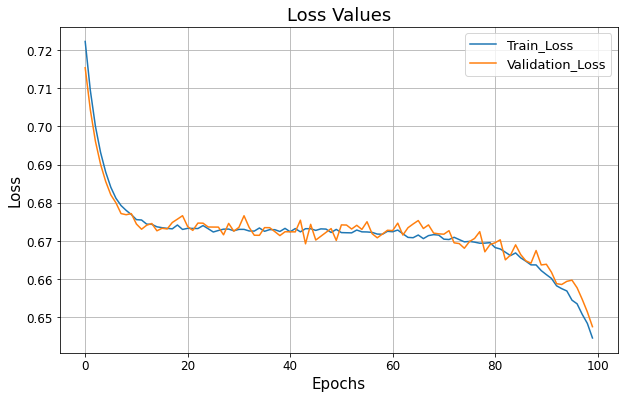

In [19]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Train_Loss')
plt.plot(validation_loss, label='Validation_Loss')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize=13)
plt.tick_params(labelsize=12)
plt.grid()
plt.title('Loss Values', fontsize=18)
plt.savefig(f'graphs/loss_b{batch_size}_e{epochs}_v2.png', dpi=600)

### Testing
#### Sample

Truth: scene 	 Prediction: scene 	 Result: Right


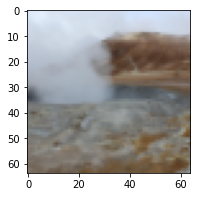

Truth: person 	 Prediction: scene 	 Result: Wrong


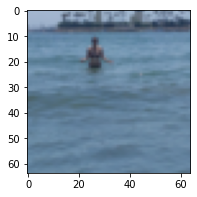

Truth: scene 	 Prediction: scene 	 Result: Right


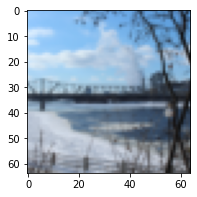

Truth: person 	 Prediction: scene 	 Result: Wrong


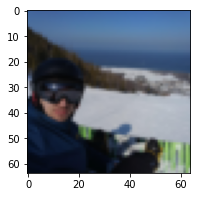

Truth: person 	 Prediction: scene 	 Result: Wrong


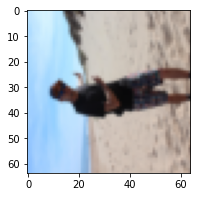

Truth: scene 	 Prediction: scene 	 Result: Right


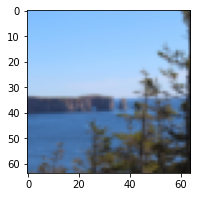

Truth: scene 	 Prediction: scene 	 Result: Right


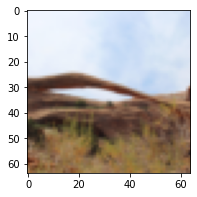

Truth: scene 	 Prediction: scene 	 Result: Right


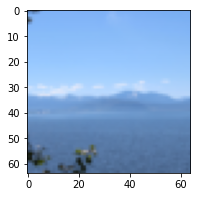

Truth: person 	 Prediction: scene 	 Result: Wrong


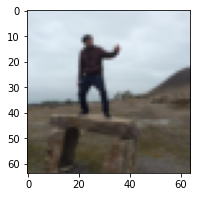

Truth: person 	 Prediction: scene 	 Result: Wrong


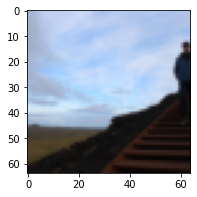

Truth: person 	 Prediction: scene 	 Result: Wrong


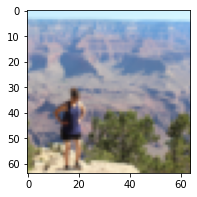

Truth: person 	 Prediction: scene 	 Result: Wrong


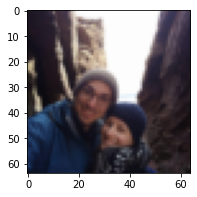

Truth: scene 	 Prediction: scene 	 Result: Right


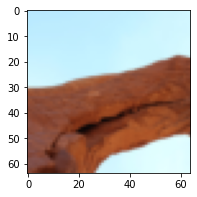

Truth: scene 	 Prediction: scene 	 Result: Right


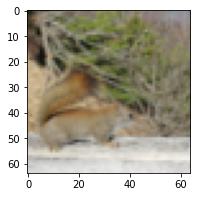

Truth: person 	 Prediction: scene 	 Result: Wrong


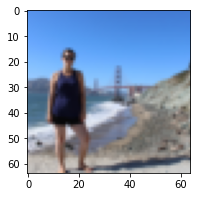

Truth: person 	 Prediction: scene 	 Result: Wrong


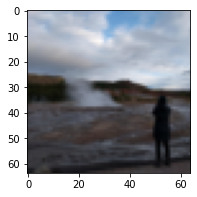

In [20]:
#load a batch from the test set
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

#generate predictions of testloader samples
cnn.eval()
outputs = cnn(images)

#the class with the highest energy is what we choose as prediction
_, predicted = torch.max(outputs, 1)

for i in range(batch_size):
    if classes[labels[i]] == classes[predicted[i]]:
        boolean = 'Right'
    else:
        boolean = 'Wrong'
    print(f'Truth: {classes[labels[i]]} \t Prediction: {classes[predicted[i]]} \t Result: {boolean}')
    imshow(images[i])

#### Complete testset

In [21]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        
        # calculate outputs by running images through the network
        outputs = cnn(data)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 597 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 597 test images: 59 %


### Script Runtime Result

In [22]:
#End Time of Training
script_end = end_time_()

#Time needed for script
print(f'Execution time of script is : {Execution_time(script_start, script_end)} hh:mm:ss')

Execution time of script is : 05:25:46 hh:mm:ss
